In [ ]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
!pip install tf_clahe --quiet

In [39]:
import pandas as pd
import numpy as np
import ast
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers,Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from sklearn.model_selection import KFold, StratifiedKFold

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

import tf_clahe

# Helper Functions and things


In [40]:
def fast_clahe(img):
    return tf_clahe.clahe(img, gpu_optimized=True)
def get_unique_count(col):
    values,counts=np.unique(col,return_counts=True)
    for i,j,k in list(zip(values,counts,counts/sum(counts))):
        print(i,j,round(k,2)) 
@tf.function(experimental_compile=True)  # Enable XLA
def fast_clahe(img):
    return tf_clahe.clahe(img, gpu_optimized=True)

In [41]:
def create_dataset(image_names,labels,clahe=None):
    images=[]
    classes=[]
    for img,label in tqdm(list(zip(image_names,labels))):
        image_path = CFG.images_path+'/'+img
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(CFG.image_size,CFG.image_size))
        except:
            continue

        if clahe:
                try:
                    image = fast_clahe(image)
                    #mage=np.array(image)
                except:
                    print(image)
        dummy=[0]*4
        dummy[label]=1
        images.append(image)
        classes.append(dummy)
    return images,classes

In [42]:
class CFG:
    csv_path='/kaggle/input/ocular-final-csv/Complete_dataset_forML.csv'
    images_path='/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images'
    image_size=224
    n_classes=4

In [43]:
from tensorflow.keras.layers.experimental import preprocessing
trainAug = Sequential([
    #preprocessing.Rescaling(scale=1.0 / 255),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomFlip("vertical"),
    #preprocessing.RandomRotation(0.9)
])

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
def get_metrics(testDS,test_y,model):
    y_preds=model.predict(testDS)
    y_preds_class=[]
    for i in y_preds:
        y_preds_class.append(np.argmax(i))
    y_test_class=[]
    for i in test_y:
        y_test_class.append(np.argmax(i))
    print(classification_report(y_test_class,y_preds_class))

In [45]:
df=pd.read_csv(CFG.csv_path)
# df['Label']= df['Label']-1
# df=df[(df['Label']==0) | (df['Label']==2) | (df['Label']==3) | (df['Label']==5)]
df=df.drop_duplicates()
df.head()

,File,Label
0,0_left.jpg,1
1,0_right.jpg,0
2,1_left.jpg,0
3,1_right.jpg,0
4,10_right.jpg,0


In [46]:
get_unique_count(df['Label'])

0 2816 0.77
1 313 0.09
2 326 0.09
3 193 0.05


In [47]:
# df.loc[df['Label']==2,'Label']=1
# df.loc[df['Label']==3,'Label']=2
# df.loc[df['Label']==5,'Label']=3

0-Normal
1- Glacuma
2-cataract
3- Hypertension

In [48]:
get_unique_count(df['Label'])

0 2816 0.77
1 313 0.09
2 326 0.09
3 193 0.05


In [49]:
df.head()

,File,Label
0,0_left.jpg,1
1,0_right.jpg,0
2,1_left.jpg,0
3,1_right.jpg,0
4,10_right.jpg,0


In [50]:
get_unique_count(df['Label'])

0 2816 0.77
1 313 0.09
2 326 0.09
3 193 0.05


In [71]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

def sampling_technique(df,test_condition):
    #594 500 397 203
    if test_condition=='Under-Sampling':
        count_class_0 = len(df[df['Label']==2])
        count_class_1 = len(df[df['Label']==1])
        count_class_2 = len(df[df['Label']==2])
        count_class_3 = len(df[df['Label']==3])
        
        pipe = make_pipeline(
        RandomUnderSampler(sampling_strategy={0: count_class_0}),
        RandomUnderSampler(sampling_strategy={1: count_class_1}),
        RandomOverSampler(sampling_strategy={2: count_class_2}),
        RandomOverSampler(sampling_strategy={3: count_class_3})
    #     RandomOverSampler(sampling_strategy={4: count_class_4}),
    #     RandomOverSampler(sampling_strategy={5: count_class_5}),
    #     RandomOverSampler(sampling_strategy={6: count_class_6}),
    #     RandomOverSampler(sampling_strategy={7: count_class_7})
        )

    if test_condition=='No-Sampling':
        count_class_0 = 2000
        count_class_1 = len(df[df['Label']==1])
        count_class_2 = len(df[df['Label']==2])
        count_class_3 = len(df[df['Label']==3])
        
        pipe = make_pipeline(
        RandomUnderSampler(sampling_strategy={0: count_class_0}),
        RandomUnderSampler(sampling_strategy={1: count_class_1}),
        RandomOverSampler(sampling_strategy={2: count_class_2}),
        RandomOverSampler(sampling_strategy={3: count_class_3})
    #     RandomOverSampler(sampling_strategy={4: count_class_4}),
    #     RandomOverSampler(sampling_strategy={5: count_class_5}),
    #     RandomOverSampler(sampling_strategy={6: count_class_6}),
    #     RandomOverSampler(sampling_strategy={7: count_class_7})
        )

    if test_condition=='Over-Sampling':
        count_class_0 = 600
        count_class_1 = 500
        count_class_2 = 500
        count_class_3 = 500

        pipe = make_pipeline(
            RandomUnderSampler(sampling_strategy={0: count_class_0}),
            RandomOverSampler(sampling_strategy={1: count_class_1}),
            RandomOverSampler(sampling_strategy={2: count_class_2}),
            RandomOverSampler(sampling_strategy={3: count_class_3})
        #     RandomOverSampler(sampling_strategy={4: count_class_4}),
        #     RandomOverSampler(sampling_strategy={5: count_class_5}),
        #     RandomOverSampler(sampling_strategy={6: count_class_6}),
        #     RandomOverSampler(sampling_strategy={7: count_class_7})
        )
    X_smt,y_smt = pipe.fit_resample(df, df['Label'])
    return X_smt

In [52]:
df=sampling_technique(df,'No-Sampling')

In [82]:
get_unique_count(df['Label'])

0 2000 0.71
1 313 0.11
2 326 0.12
3 193 0.07


# Getting Train, Validation and Test

In [53]:

train, test = train_test_split(df, test_size=0.10, stratify=df['Label'],random_state=1) 
train,val= train_test_split(train, test_size=0.10, random_state=1,stratify=train['Label'])

print("train",len(train))
print("test",len(test))
print("Val",len(val))


train 2293
test 284
Val 255


In [25]:
get_unique_count(train['Label'])

0 1619 0.71
1 254 0.11
2 264 0.12
3 156 0.07


In [26]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)
val.to_csv('val.csv',index=False)


In [27]:
#train=X_smt

In [28]:
print(get_unique_count(train['Label'].values))
print(get_unique_count(val['Label'].values))
print(get_unique_count(test['Label'].values))

0 1619 0.71
1 254 0.11
2 264 0.12
3 156 0.07
None
0 180 0.71
1 28 0.11
2 29 0.11
3 18 0.07
None
0 201 0.71
1 31 0.11
2 33 0.12
3 19 0.07
None


In [29]:
train_x,train_y = create_dataset(train['File'].values,train['Label'].values)
val_x,val_y = create_dataset(val['File'].values,val['Label'].values)
test_x,test_y = create_dataset(test['File'].values,test['Label'].values)

100%|██████████| 284/284 [00:02<00:00, 108.73it/s]


In [30]:
#get_unique_count()

In [31]:
print("train_img_X: ",np.array(train_x).shape)
print("test_img_X: ",np.array(test_x).shape)
print("train_labels: ",np.array(train_y).shape)
print("test_labels: ",np.array(test_y).shape)

train_img_X:  (2272, 224, 224, 3)
test_img_X:  (281, 224, 224, 3)
train_labels:  (2272, 4)
test_labels:  (281, 4)


In [32]:
np.array(train_x).shape

(2272, 224, 224, 3)

In [33]:
trainDS = tf.data.Dataset.from_tensor_slices((train_x,train_y))
valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y))
testDS = tf.data.Dataset.from_tensor_slices((test_x,test_y))

2022-12-12 05:22:52.821986: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2735996928 exceeds 10% of free system memory.


In [34]:
trainDS=trainDS.batch(16).prefetch(tf.data.AUTOTUNE)
valDS=valDS.batch(16).prefetch(tf.data.AUTOTUNE)
testDS=testDS.batch(16).prefetch(tf.data.AUTOTUNE)

# Model Training

## Different models

In [35]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB7
from tensorflow.keras.applications.xception import Xception

In [25]:
def baseline_model(model):
        vgg = model
        vgg.trainable=False
        input_layer = layers.Input(shape=(CFG.image_size,CFG.image_size,3), name='input') 
        
        ptm = vgg(input_layer)

        l1 = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(ptm)
        l2 = layers.BatchNormalization()(l1)       
        l3 = layers.Dense(128,activation='relu')(l2)

#         l4 = layers.BatchNormalization()(l3)       
#         l5 = layers.Dense(128,activation='relu')(l4)

        
        output = layers.Dense(units=CFG.n_classes, 
                              activation='softmax', 
                              name='output')(l3)
        model = Model (input_layer, output)    
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002), 
                      loss='categorical_crossentropy', 
                      metrics=[ 'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
        return model

# efficient_model=baseline_model()
# efficient_model.summary()

In [37]:
vgg = baseline_model(VGG19(weights="imagenet",include_top = False,input_shape=(CFG.image_size,CFG.image_size,3)))

80150528/80134624 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [38]:
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 4)                 516       
Total params: 20,092,612
Trainable params: 67,204
Non-trainable params: 20,025,408
____________________________________________

In [39]:
# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')])

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('name.h5',monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [41]:
vgg.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1,callbacks=[checkpoint])

Epoch 1/15


2022-12-12 05:25:51.904704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-12 05:25:52.872740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


142/142 [==============================] - 17s 57ms/step - loss: 1.0850 - accuracy: 0.5665 - precision: 0.6714 - recall: 0.4604 - val_loss: 0.6143 - val_accuracy: 0.8063 - val_precision: 0.8670 - val_recall: 0.6957
Epoch 2/15
142/142 [==============================] - 6s 45ms/step - loss: 0.5974 - accuracy: 0.7945 - precision: 0.8251 - recall: 0.7390 - val_loss: 0.5215 - val_accuracy: 0.8221 - val_precision: 0.8655 - val_recall: 0.7628
Epoch 3/15
142/142 [==============================] - 6s 45ms/step - loss: 0.4908 - accuracy: 0.8301 - precision: 0.8558 - recall: 0.7967 - val_loss: 0.4906 - val_accuracy: 0.8221 - val_precision: 0.8528 - val_recall: 0.7787
Epoch 4/15
142/142 [==============================] - 6s 45ms/step - loss: 0.4200 - accuracy: 0.8565 - precision: 0.8801 - recall: 0.8305 - val_loss: 0.4766 - val_accuracy: 0.8221 - val_precision: 0.8426 - val_recall: 0.7826
Epoch 5/15
142/142 [==============================] - 6s 45ms/step - loss: 0.3651 - accuracy: 0.8829 - precisi

#### VGG19

In [42]:
get_metrics(testDS,test_y,vgg)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       201
           1       0.88      0.77      0.82        30
           2       0.29      0.23      0.25        31
           3       0.40      0.21      0.28        19

    accuracy                           0.77       281
   macro avg       0.60      0.53      0.55       281
weighted avg       0.74      0.77      0.75       281



In [43]:
# data= model.evaluate(testDS)
# print(data)

In [51]:
#for efficient net
b0=tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
b7=tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
b4=tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
xception=tf.keras.applications.xception.Xception(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))


234561536/234545216 [==============================] - 8s 0us/step


#### EfficientnetB0

In [30]:
effb0=baseline_model(b0)
effb0.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1)

NameError: name 'b0' is not defined

In [46]:
get_metrics(testDS,test_y,effb0)# Get mertic table for B0

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       201
           1       0.86      0.80      0.83        30
           2       0.72      0.42      0.53        31
           3       0.44      0.37      0.40        19

    accuracy                           0.82       281
   macro avg       0.72      0.63      0.66       281
weighted avg       0.81      0.82      0.81       281



#### EfficientnetB4

In [47]:
effb4=baseline_model(b4)
effb4.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1,callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
142/142 [==============================] - 22s 81ms/step - loss: 0.7921 - accuracy: 0.7232 - precision: 0.7742 - recall: 0.6717 - val_loss: 0.6985 - val_accuracy: 0.8063 - val_precision: 0.8522 - val_recall: 0.6838
Epoch 2/15
142/142 [==============================] - 9s 61ms/step - loss: 0.5578 - accuracy: 0.7962 - precision: 0.8153 - recall: 0.7716 - val_loss: 0.5598 - val_accuracy: 0.8419 - val_precision: 0.8761 - val_recall: 0.7826
Epoch 3/15
142/142 [==============================] - 9s 61ms/step - loss: 0.5112 - accuracy: 0.8165 - precision: 0.8349 - recall: 0.7945 - val_loss: 0.4813 - val_accuracy: 0.8419 - val_precision: 0.8636 - val_recall: 0.8261
Epoch 4/15
142/142 [==============================] - 9s 61ms/step - loss: 0.4446 - accuracy: 0.8420 - precision: 0.8612 - recall: 0.8217 - val_loss: 0.4622 - val_accuracy: 0.8538 - val_precision: 0.8667 - val_recall: 0.8221
Epoch 5/15
142/142 [==============================] - 9s 61ms/step - loss: 0.4075 - accuracy: 0.853

In [48]:
get_metrics(testDS,test_y,effb4)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       201
           1       0.84      0.90      0.87        30
           2       0.65      0.35      0.46        31
           3       0.50      0.42      0.46        19

    accuracy                           0.84       281
   macro avg       0.72      0.65      0.67       281
weighted avg       0.82      0.84      0.82       281



#### Resnet152v2

In [52]:
effb7=baseline_model(b7)
effb7.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1,callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
142/142 [==============================] - 23s 110ms/step - loss: 0.9928 - accuracy: 0.6805 - precision: 0.7039 - recall: 0.6017 - val_loss: 0.8644 - val_accuracy: 0.7233 - val_precision: 0.7317 - val_recall: 0.7115
Epoch 2/15
142/142 [==============================] - 12s 85ms/step - loss: 0.8212 - accuracy: 0.7161 - precision: 0.7466 - recall: 0.6822 - val_loss: 0.8197 - val_accuracy: 0.7233 - val_precision: 0.7404 - val_recall: 0.6877
Epoch 3/15
142/142 [==============================] - 12s 84ms/step - loss: 0.7425 - accuracy: 0.7434 - precision: 0.7735 - recall: 0.7064 - val_loss: 0.7986 - val_accuracy: 0.7233 - val_precision: 0.7521 - val_recall: 0.6957
Epoch 4/15
142/142 [==============================] - 12s 85ms/step - loss: 0.6855 - accuracy: 0.7606 - precision: 0.7885 - recall: 0.7284 - val_loss: 0.7798 - val_accuracy: 0.7312 - val_precision: 0.7500 - val_recall: 0.6996
Epoch 5/15
142/142 [==============================] - 12s 84ms/step - loss: 0.6412 - accuracy: 

In [53]:
get_metrics(testDS,test_y,effb7)# Get mertic table for B7

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       201
           1       0.50      0.40      0.44        30
           2       0.27      0.10      0.14        31
           3       0.50      0.05      0.10        19

    accuracy                           0.71       281
   macro avg       0.51      0.37      0.38       281
weighted avg       0.66      0.71      0.66       281



#### Exception

In [49]:
xception=baseline_model(xception)
xception.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1,callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
142/142 [==============================] - 11s 55ms/step - loss: 0.9783 - accuracy: 0.6562 - precision: 0.6982 - recall: 0.5783 - val_loss: 0.6718 - val_accuracy: 0.7787 - val_precision: 0.8043 - val_recall: 0.7470
Epoch 2/15
142/142 [==============================] - 7s 48ms/step - loss: 0.6229 - accuracy: 0.7865 - precision: 0.8070 - recall: 0.7452 - val_loss: 0.6570 - val_accuracy: 0.7945 - val_precision: 0.8017 - val_recall: 0.7510
Epoch 3/15
142/142 [==============================] - 7s 49ms/step - loss: 0.4989 - accuracy: 0.8222 - precision: 0.8446 - recall: 0.7945 - val_loss: 0.6805 - val_accuracy: 0.7945 - val_precision: 0.8058 - val_recall: 0.7708
Epoch 4/15
142/142 [==============================] - 7s 48ms/step - loss: 0.4087 - accuracy: 0.8517 - precision: 0.8783 - recall: 0.8257 - val_loss: 0.7156 - val_accuracy: 0.8024 - val_precision: 0.8008 - val_recall: 0.7787
Epoch 5/15
142/142 [==============================] - 7s 48ms/step - loss: 0.3385 - accuracy: 0.886

In [50]:
get_metrics(testDS,test_y,xception)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       201
           1       0.54      0.50      0.52        30
           2       0.25      0.03      0.06        31
           3       0.13      0.11      0.12        19

    accuracy                           0.69       281
   macro avg       0.42      0.38      0.38       281
weighted avg       0.63      0.69      0.65       281



# Augmentations

In [83]:

train_x,train_y = create_dataset(train['File'].values,train['Label'].values,clahe=True)
val_x,val_y = create_dataset(val['File'].values,val['Label'].values,clahe=True)
test_x,test_y = create_dataset(test['File'].values,test['Label'].values,clahe=True)

100%|██████████| 284/284 [00:01<00:00, 198.54it/s]


In [84]:
trainDS = tf.data.Dataset.from_tensor_slices((train_x,train_y))
valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y))
testDS = tf.data.Dataset.from_tensor_slices((test_x,test_y))

In [85]:
trainDS=trainDS.batch(16).prefetch(tf.data.AUTOTUNE)
valDS=valDS.batch(16).prefetch(tf.data.AUTOTUNE)
testDS=testDS.batch(16).prefetch(tf.data.AUTOTUNE)

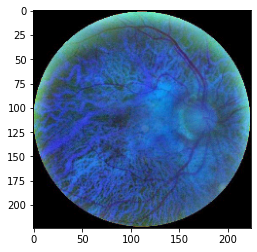

In [86]:
plt.imshow(np.array(train_x)[0])

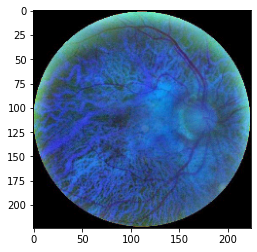

In [87]:
plt.imshow(np.array(train_x)[0])

In [88]:
trainDS_noaug=trainDS.batch(16).prefetch(tf.data.AUTOTUNE)
trainDSAug = (
    trainDS.batch(16)
    .map(lambda x, y: (trainAug(x), y))
)

#### No augmentations- only clahe

In [89]:
b4=tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
effb4=baseline_model(b4)
effb4.fit(trainDS_noaug,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
142/142 [==============================] - 23s 79ms/step - loss: 0.8599 - accuracy: 0.6950 - precision: 0.7510 - recall: 0.6426 - val_loss: 0.7031 - val_accuracy: 0.7945 - val_precision: 0.8389 - val_recall: 0.6996
Epoch 2/15
142/142 [==============================] - 9s 61ms/step - loss: 0.5838 - accuracy: 0.8011 - precision: 0.8216 - recall: 0.7782 - val_loss: 0.5838 - val_accuracy: 0.8103 - val_precision: 0.8362 - val_recall: 0.7668
Epoch 3/15
142/142 [==============================] - 9s 62ms/step - loss: 0.4912 - accuracy: 0.8266 - precision: 0.8459 - recall: 0.8068 - val_loss: 0.5184 - val_accuracy: 0.8103 - val_precision: 0.8250 - val_recall: 0.7826
Epoch 4/15
142/142 [==============================] - 9s 60ms/step - loss: 0.4552 - accuracy: 0.8429 - precision: 0.8581 - recall: 0.8253 - val_loss: 0.5010 - val_accuracy: 0.8221 - val_precision: 0.8367 - val_recall: 0.8103
Epoch 5/15
142/142 [==============================] - 9s 60ms/step - loss: 0.4047 - accuracy: 0.861

In [90]:
get_metrics(testDS,test_y,effb4)# Get mertic table for B0

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       201
           1       0.93      0.83      0.88        30
           2       0.69      0.29      0.41        31
           3       0.43      0.32      0.36        19

    accuracy                           0.82       281
   macro avg       0.72      0.60      0.64       281
weighted avg       0.81      0.82      0.80       281



### With augmentations only horizontalflip

In [54]:
train_x,train_y = create_dataset(train['File'].values,train['Label'].values)
val_x,val_y = create_dataset(val['File'].values,val['Label'].values)
test_x,test_y = create_dataset(test['File'].values,test['Label'].values)

100%|██████████| 284/284 [00:01<00:00, 158.36it/s]


In [55]:
trainDS = tf.data.Dataset.from_tensor_slices((train_x,train_y))
valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y))
testDS = tf.data.Dataset.from_tensor_slices((test_x,test_y))

2022-12-12 15:26:13.596832: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2737201152 exceeds 10% of free system memory.


In [56]:
trainDS=trainDS.batch(16).map(lambda x, y: (trainAug(x), y)).prefetch(tf.data.AUTOTUNE)
valDS=valDS.batch(16).prefetch(tf.data.AUTOTUNE)
testDS=testDS.batch(16).prefetch(tf.data.AUTOTUNE)

In [57]:
# trainDSAug = (
#     trainDS.batch(16)
#     .map(lambda x, y: (trainAug(x), y))
# )
b4=tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))

In [35]:
effb4_aug=baseline_model(b4)
effb4_aug.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
143/143 [==============================] - 12s 49ms/step - loss: 0.7922 - accuracy: 0.7216 - precision: 0.7806 - recall: 0.6588 - val_loss: 0.7273 - val_accuracy: 0.8048 - val_precision: 0.8691 - val_recall: 0.6614
Epoch 2/15
143/143 [==============================] - 5s 38ms/step - loss: 0.5669 - accuracy: 0.7995 - precision: 0.8239 - recall: 0.7735 - val_loss: 0.5952 - val_accuracy: 0.8247 - val_precision: 0.8716 - val_recall: 0.7570
Epoch 3/15
143/143 [==============================] - 6s 43ms/step - loss: 0.4802 - accuracy: 0.8281 - precision: 0.8469 - recall: 0.8078 - val_loss: 0.5213 - val_accuracy: 0.8287 - val_precision: 0.8528 - val_recall: 0.7849
Epoch 4/15
143/143 [==============================] - 6s 39ms/step - loss: 0.4519 - accuracy: 0.8395 - precision: 0.8571 - recall: 0.8179 - val_loss: 0.5029 - val_accuracy: 0.8287 - val_precision: 0.8465 - val_recall: 0.8127
Epoch 5/15
143/143 [==============================] - 6s 39ms/step - loss: 0.4068 - accuracy: 0.856

In [36]:
get_metrics(testDS,test_y,effb4_aug)# Get mertic table for B0

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       201
           1       0.84      0.90      0.87        30
           2       0.45      0.29      0.35        31
           3       0.54      0.37      0.44        19

    accuracy                           0.81       281
   macro avg       0.67      0.62      0.64       281
weighted avg       0.79      0.81      0.79       281



In [108]:
#train=sampling_technique(train,'Over-Sampling')

# OverSampling

In [112]:
# train=pd.read_csv('/kaggle/working/train.csv')
# val=pd.read_csv('/kaggle/working/val.csv')
# test=pd.read_csv('/kaggle/working/test.csv')

In [72]:
df=pd.read_csv(CFG.csv_path)
df=df.drop_duplicates()

train, test = train_test_split(df, test_size=0.10, stratify=df['Label'],random_state=1) 
train,val= train_test_split(train, test_size=0.10, random_state=1,stratify=train['Label'])

print("train",len(train))
print("test",len(test))
print("Val",len(val))

train 2954
test 365
Val 329


In [73]:
train_up=sampling_technique(train,'Over-Sampling')

In [74]:
get_unique_count(train_up['Label'])

0 600 0.29
1 500 0.24
2 500 0.24
3 500 0.24


In [75]:
get_unique_count(val['Label'])

0 254 0.77
1 28 0.09
2 29 0.09
3 18 0.05


In [76]:
train_x,train_y = create_dataset(train_up['File'].values,train_up['Label'].values)
val_x,val_y = create_dataset(val['File'].values,val['Label'].values)
test_x,test_y = create_dataset(test['File'].values,test['Label'].values)

100%|██████████| 365/365 [00:01<00:00, 232.88it/s]


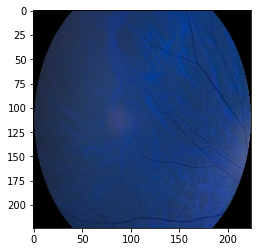

In [77]:
plt.imshow(val_x[0])

In [78]:
trainDS = tf.data.Dataset.from_tensor_slices((train_x,train_y))
valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y))
testDS = tf.data.Dataset.from_tensor_slices((test_x,test_y))

2022-12-12 15:53:12.386177: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2477088768 exceeds 10% of free system memory.


In [79]:
trainDS=trainDS.batch(16).prefetch(tf.data.AUTOTUNE)
valDS=valDS.batch(16).prefetch(tf.data.AUTOTUNE)
testDS=testDS.batch(16).prefetch(tf.data.AUTOTUNE)

In [80]:
b0=tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
effb0=baseline_model(b0)
effb0.fit(trainDS,batch_size=16,epochs=10,validation_data=(valDS),
                    verbose=1)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
129/129 [==============================] - 21s 85ms/step - loss: 1.3302 - accuracy: 0.5391 - precision: 0.5813 - recall: 0.4604 - val_loss: 2.1983 - val_accuracy: 0.0552 - val_precision: 0.1905 - val_recall: 0.0123
Epoch 2/10
129/129 [==============================] - 8s 65ms/step - loss: 1.1138 - accuracy: 0.6018 - precision: 0.6478 - recall: 0.4954 - val_loss: 2.4510 - val_accuracy: 0.0951 - val_precision: 0.1165 - val_recall: 0.0368
Epoch 3/10
129/129 [==============================] - 8s 65ms/step - loss: 0.8412 - accuracy: 0.6757 - precision: 0.7322 - recall: 0.6087 - val_loss: 2.6732 - val_accuracy: 0.1043 - val_precision: 0.1152 - val_recall: 0.0583
Epoch 4/10
129/129 [==============================] - 8s 66ms/step - loss: 0.6852 - accuracy: 0.7341 - precision: 0.7898 - recall: 0.6650 - val_loss: 2.7687 - val_accuracy: 0.0982 - val_precision: 0.0852 - val_recall: 0.0583
Epoch 5/10
129/129 [==============================] - 8s 65ms/step - loss: 0.5761 - accuracy: 0.778

In [81]:
get_metrics(testDS,test_y,effb0)

              precision    recall  f1-score   support

           0       0.86      0.07      0.12       282
           1       0.41      0.40      0.41        30
           2       0.09      0.62      0.16        32
           3       0.03      0.16      0.06        19

    accuracy                           0.15       363
   macro avg       0.35      0.31      0.19       363
weighted avg       0.71      0.15      0.15       363



# Under-Sampling

In [144]:
df=pd.read_csv(CFG.csv_path)
df=df.drop_duplicates()

train, test = train_test_split(df, test_size=0.10, stratify=df['Label'],random_state=1) 
train,val= train_test_split(train, test_size=0.10, random_state=1,stratify=train['Label'])

print("train",len(train))
print("test",len(test))
print("Val",len(val))

train 2954
test 365
Val 329


In [145]:
train_down=sampling_technique(train,'Under-Sampling')

In [146]:
get_unique_count(train_down['Label'])

0 264 0.28
1 254 0.27
2 264 0.28
3 156 0.17


In [147]:
get_unique_count(val['Label'])

0 254 0.77
1 28 0.09
2 29 0.09
3 18 0.05


In [148]:
train_x,train_y = create_dataset(train_down['File'].values,train_down['Label'].values,clahe=True)
val_x,val_y = create_dataset(val['File'].values,val['Label'].values,clahe=True)
test_x,test_y = create_dataset(test['File'].values,test['Label'].values,clahe=True)

100%|██████████| 365/365 [00:02<00:00, 180.65it/s]


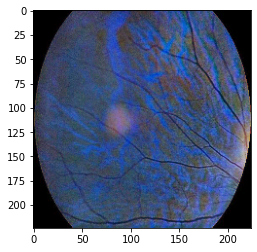

In [149]:
plt.imshow(val_x[0])

In [150]:
trainDS = tf.data.Dataset.from_tensor_slices((train_x,train_y))
valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y))
testDS = tf.data.Dataset.from_tensor_slices((test_x,test_y))

In [151]:
trainDS=trainDS.batch(16).prefetch(tf.data.AUTOTUNE)
valDS=valDS.batch(16).prefetch(tf.data.AUTOTUNE)
testDS=testDS.batch(16).prefetch(tf.data.AUTOTUNE)

In [152]:
b0=tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
effb0=baseline_model(b0)
effb0.fit(trainDS,batch_size=16,epochs=10,validation_data=(valDS),
                    verbose=1)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
58/58 [==============================] - 17s 129ms/step - loss: 2.1107 - accuracy: 0.2704 - precision: 0.2675 - recall: 0.1996 - val_loss: 1.7068 - val_accuracy: 0.1227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
58/58 [==============================] - 4s 73ms/step - loss: 1.3499 - accuracy: 0.4286 - precision: 0.5168 - recall: 0.2519 - val_loss: 1.8145 - val_accuracy: 0.1012 - val_precision: 0.0909 - val_recall: 0.0123
Epoch 3/10
58/58 [==============================] - 4s 74ms/step - loss: 1.2203 - accuracy: 0.4537 - precision: 0.5589 - recall: 0.2846 - val_loss: 1.7645 - val_accuracy: 0.1074 - val_precision: 0.1250 - val_recall: 0.0215
Epoch 4/10
58/58 [==============================] - 4s 73ms/step - loss: 1.0514 - accuracy: 0.5333 - precision: 0.6494 - recall: 0.3697 - val_loss: 1.6954 - val_accuracy: 0.1104 - val_precision: 0.1972 - val_recall: 0.0429
Epoch 5/10
58/58 [==============================] - 5s 79ms/step - loss: 0.8937 - accuracy: 0.6238

In [153]:
get_metrics(testDS,test_y,effb0)

              precision    recall  f1-score   support

           0       0.65      0.05      0.09       282
           1       0.43      0.50      0.46        30
           2       0.08      0.78      0.15        32
           3       0.25      0.11      0.15        19

    accuracy                           0.15       363
   macro avg       0.35      0.36      0.21       363
weighted avg       0.56      0.15      0.13       363



# K-fold ensemble

In [154]:
CFG.folds=5

In [155]:
df=pd.read_csv(CFG.csv_path)
df=sampling_technique(df,'No-Sampling')

In [156]:
train, test = train_test_split(df, test_size=0.10, stratify=df['Label'],random_state=1) 
train['k-fold']=-1
train=train.reset_index()

In [157]:
train.head()

,index,File,Label,k-fold
0,59,2568_left.jpg,0,-1
1,1864,2710_right.jpg,0,-1
2,495,2697_left.jpg,0,-1
3,312,2711_left.jpg,0,-1
4,329,4172_right.jpg,0,-1


In [158]:
for i,(train_index, test_index) in enumerate(StratifiedKFold(n_splits=3).split(train,train['Label'])):
    train.loc[test_index,'k-fold']=i+1

In [166]:
get_unique_count(train[train['k-fold']==1]['Label'])

1 850 0.33
2 849 0.33
3 849 0.33


In [167]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [168]:
for i in range(1,CFG.folds+1):
    print('*********'+'Fold:'+str(i)+'**************')
    train_d=train[(train['k-fold']!=i)]
    train_v=train[(train['k-fold']==i)]
    train_X,train_Y = create_dataset(train_d['File'].values,train_d['Label'].values,clahe=True)
    val_x,val_y = create_dataset(train_v['File'].values,train_v['Label'].values,clahe=True)
    trainDS = tf.data.Dataset.from_tensor_slices((train_X,train_Y)).batch(16)
    valDS = tf.data.Dataset.from_tensor_slices((val_x,val_y)).batch(16)
    model_name='efficient_net_fold_'+str(i)
    checkpoint = ModelCheckpoint(model_name+'.h5',monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
    b0=tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',input_shape=(CFG.image_size,CFG.image_size,3))
    effb0=baseline_model(b0)
    history=effb0.fit(trainDS,batch_size=16,epochs=15,validation_data=(valDS),
                        verbose=1,callbacks=[checkpoint])

*********Fold:1**************


100%|██████████| 850/850 [00:04<00:00, 192.64it/s]


Epoch 1/15
106/106 [==============================] - 21s 107ms/step - loss: 0.8575 - accuracy: 0.6980 - precision: 0.7537 - recall: 0.6332 - val_loss: 0.7623 - val_accuracy: 0.7675 - val_precision: 0.8422 - val_recall: 0.6584
Epoch 2/15
106/106 [==============================] - 9s 83ms/step - loss: 0.5666 - accuracy: 0.8062 - precision: 0.8278 - recall: 0.7776 - val_loss: 0.6559 - val_accuracy: 0.7888 - val_precision: 0.8459 - val_recall: 0.7165
Epoch 3/15
106/106 [==============================] - 9s 81ms/step - loss: 0.4979 - accuracy: 0.8276 - precision: 0.8457 - recall: 0.8050 - val_loss: 0.5922 - val_accuracy: 0.7972 - val_precision: 0.8368 - val_recall: 0.7544
Epoch 4/15
106/106 [==============================] - 9s 81ms/step - loss: 0.4444 - accuracy: 0.8454 - precision: 0.8598 - recall: 0.8276 - val_loss: 0.5502 - val_accuracy: 0.8019 - val_precision: 0.8221 - val_recall: 0.7675
Epoch 5/15
106/106 [==============================] - 9s 83ms/step - loss: 0.3919 - accuracy: 0.85

100%|██████████| 849/849 [00:04<00:00, 205.68it/s]


Epoch 1/15
106/106 [==============================] - 21s 111ms/step - loss: 0.7512 - accuracy: 0.7467 - precision: 0.7731 - recall: 0.7010 - val_loss: 0.7984 - val_accuracy: 0.7770 - val_precision: 0.8710 - val_recall: 0.5848
Epoch 2/15
106/106 [==============================] - 9s 81ms/step - loss: 0.5632 - accuracy: 0.8109 - precision: 0.8233 - recall: 0.7866 - val_loss: 0.6966 - val_accuracy: 0.7972 - val_precision: 0.8618 - val_recall: 0.6655
Epoch 3/15
106/106 [==============================] - 9s 85ms/step - loss: 0.5025 - accuracy: 0.8282 - precision: 0.8475 - recall: 0.8062 - val_loss: 0.6140 - val_accuracy: 0.7995 - val_precision: 0.8478 - val_recall: 0.7402
Epoch 4/15
106/106 [==============================] - 9s 82ms/step - loss: 0.4222 - accuracy: 0.8484 - precision: 0.8639 - recall: 0.8306 - val_loss: 0.5596 - val_accuracy: 0.8149 - val_precision: 0.8338 - val_recall: 0.7734
Epoch 5/15
106/106 [==============================] - 9s 83ms/step - loss: 0.3966 - accuracy: 0.86

KeyboardInterrupt: 